In [103]:
import random
import keras
import os, glob
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential, model_from_json
from keras import backend as K
from keras.optimizers import Adam

from imblearn.over_sampling import RandomOverSampler


In [55]:
DATA_DIR_GUITAR = "./data/audio/Guitar_Only/"
CLASSES = ['a', 'am', 'bm', 'c', 'd', 'dm', 'e', 'em', 'f', 'g']
CLASSES_MAP = {'a':0, 'am':1, 'bm':2, 'c':3, 'd':4, 'dm':5, 'e':6, 'em':7, 'f':8, 'g':9}
METADATA_DIR_RAW = "./data/metadata/raw/"
METADATA_DIR_PROCESSED = "./data/metadata/processed/"
DATA_DIR_AUGMENTED = "./data/augmented/"
METADATA_DIR_AUGMENTED_RAW = "./data/augmented/raw"
METADATA_DIR_AUGMENTED_PROCESSED = "./data/augmented/processed"

In [3]:
len(glob.glob(DATA_DIR_GUITAR + "**/*.wav"))

2000

### Generate Metadata

In [4]:
def df_info(f):
    def inner(df, *args, **kwargs):
        result = f(df, *args, **kwargs)
        print(f"After applying {f.__name__}, shape of df = {result.shape }")
        print(f"Columns of df are {df.columns}\n")
        return result
    return inner

# Construct Dataframe with all required values
@df_info
def construct_dataframe(df):
    df['file_path'] = file_path
    df['file_path'] = df['file_path'].map(lambda x: x[x.rindex('Only\\')+len('Only\\'):])
    df['file_name'] = df['file_path'].map(lambda x: x[x.rindex('\\')+1:])
    df['class_name'] = df['file_path'].map(lambda x: x[:x.index('\\')])
    df['class_ID'] = df['class_name'].map(lambda x: CLASSES_MAP[x])
    return df.copy()

# Extract spectrogram from audio
@df_info
def get_spectrogram(df):
    df['audio_series'] = df['file_path'].map(lambda x: librosa.load(DATA_DIR_GUITAR + x, duration=2))
    df['y'] = df['audio_series'].map(lambda x: x[0])
    df['sr'] = df['audio_series'].map(lambda x: x[1])
    df['spectrogram'] = df.apply(lambda row: librosa.feature.melspectrogram(y=row['y'], sr=row['sr']), axis=1)
    df.drop(columns='audio_series', inplace=True)
    return df

@df_info
def get_count(df):
    return df['class_name'].value_counts()

@df_info
def add_shape(df):
    df['shape'] = df['spectrogram'].map(lambda x: x.shape)
    return df

### Generate raw data

In [5]:
file_path = glob.glob("./data/audio/Guitar_Only/" + "**/*.wav")
data_df_raw = (pd.DataFrame().pipe(construct_dataframe)
                            .pipe(get_spectrogram)
                             .pipe(add_shape)
            )


After applying construct_dataframe, shape of df = (2000, 4)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID'], dtype='object')

After applying get_spectrogram, shape of df = (2000, 7)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram'],
      dtype='object')

After applying add_shape, shape of df = (2000, 8)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape'],
      dtype='object')



In [6]:
get_count(data_df_raw)

After applying get_count, shape of df = (10,)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape'],
      dtype='object')



a     200
am    200
bm    200
c     200
d     200
dm    200
e     200
em    200
f     200
g     200
Name: class_name, dtype: int64

### Save raw data


In [7]:
data_df_raw.to_csv(os.path.join(METADATA_DIR_RAW, 'data.csv'), index=False)
data_df_raw.to_pickle(os.path.join(METADATA_DIR_RAW, 'data.pkl'))

In [8]:
data_df_raw = pd.read_pickle(os.path.join(METADATA_DIR_RAW, 'data.pkl'))

In [ ]:
data_df_raw.head()

### Process and save processed data

In [9]:
# Maintain same shape
@df_info
def clean_shape(df):
    max_shape = df['spectrogram'].map(lambda x: x.shape).value_counts().index[0]
    print(f"The most frequent shape is {max_shape}")
    df['shape'] = df['spectrogram'].map(lambda x: x.shape)
    df = df[df['shape']==max_shape]
    df.drop(columns='shape', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

@df_info
def process(df):
    df = (df.pipe(clean_shape)
                .pipe(over_sample)
    )
    df = df[['spectrogram','class_ID', 'class_name']]
    return df

#Over sampling data
@df_info
def over_sample(df):
    oversample = RandomOverSampler(sampling_strategy='auto')
    X, y = df['spectrogram'].values, df['class_ID'].values
    X = X.reshape(-1, 1)
    X, y = oversample.fit_resample(X, y)
    df = pd.DataFrame()
    df['spectrogram'] = pd.Series([np.array(x[0]) for x in X])
    df['class_ID'] = pd.Series(y)
    df['class_name'] = df['class_ID'].map(lambda x: get_class(x))
    return df

def get_class(class_ID):
    return list(CLASSES_MAP.keys())[list(CLASSES_MAP.values()).index(class_ID)]

In [10]:
data_df_processed = process(data_df_raw)

The most frequent shape is (128, 87)
After applying clean_shape, shape of df = (633, 7)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape'],
      dtype='object')

After applying over_sample, shape of df = (1150, 3)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram'],
      dtype='object')

After applying process, shape of df = (1150, 3)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape'],
      dtype='object')



C:\Users\Shiva Kumar\AppData\Local\Temp\ipykernel_26788\1589077470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='shape', inplace=True)


In [11]:
get_count(data_df_processed)

After applying get_count, shape of df = (10,)
Columns of df are Index(['spectrogram', 'class_ID', 'class_name'], dtype='object')



a     115
am    115
bm    115
c     115
d     115
dm    115
e     115
em    115
f     115
g     115
Name: class_name, dtype: int64

In [12]:
data_df_processed.to_csv(os.path.join(METADATA_DIR_PROCESSED, 'data.csv'), index=False)
data_df_processed.to_pickle(os.path.join(METADATA_DIR_PROCESSED, 'data.pkl'))

In [ ]:
data_df_processed.head()

### Examples of Siren spectrograms

In [ ]:
y, sr = librosa.load(DATA_DIR_GUITAR+data_df_raw['file_path'].iloc[0],duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

In [ ]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [ ]:
y, sr = librosa.load(DATA_DIR_GUITAR+data_df_raw['file_path'].iloc[201],duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr,)
ps.shape


In [ ]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [ ]:
y, sr = librosa.load(DATA_DIR_GUITAR+data_df_raw['file_path'].iloc[401],duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr,)
ps.shape


In [ ]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [ ]:
y, sr = librosa.load(DATA_DIR_GUITAR+data_df_raw['file_path'].iloc[801],duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr,)
ps.shape


In [ ]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

## Training

### Load processed data

In [13]:
dataset = pd.read_pickle(os.path.join(METADATA_DIR_PROCESSED, 'data.pkl'))

In [14]:
print("Number of samples: ", len(dataset))

Number of samples:  1150


In [ ]:
dataset.iloc[0]

In [ ]:
dataset['spectrogram'].iloc[0].shape

### Splitting into train and test

In [15]:
np.random.seed(42)
sample = np.random.choice(dataset.index, size=int(len(dataset)*0.8), replace=False)
train_data, test_data = dataset.iloc[sample], dataset.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])

Number of training samples is 920
Number of testing samples is 230
                                           spectrogram  class_ID class_name
174  [[0.005131787, 0.007499365, 0.0060594357, 0.00...         3          c
752  [[0.00054565433, 0.00068049034, 0.00044531203,...         2         bm
467  [[0.0002861476, 0.00029724906, 0.00054549635, ...         6          e
240  [[0.00024178192, 0.00020344825, 0.0005125338, ...         3          c
667  [[7.849557e-05, 7.7419565e-05, 4.931826e-05, 0...         0          a
218  [[4.0637336e-05, 2.8319037e-05, 1.5888332e-05,...         3          c
867  [[0.00083518715, 0.001044225, 0.0008323917, 0....         4          d
420  [[0.022283832, 0.009524431, 0.007829224, 0.008...         6          e
351  [[0.0007388318, 0.0010725782, 0.0007419601, 0....         5         dm
328  [[9.781871e-05, 0.0001397526, 0.00011793934, 0...         4          d
                                          spectrogram  class_ID class_name
1   [[0.007935312, 0.0

In [ ]:
train_data['spectrogram'].iloc[0]

In [16]:
print(train_data.iloc[0])
print(train_data.iloc[0][0].shape)   #shape of input image
print(train_data.iloc[0][0][0][1])
print(train_data.iloc[0][1])    #output class id

spectrogram    [[0.005131787, 0.007499365, 0.0060594357, 0.00...
class_ID                                                       3
class_name                                                     c
Name: 174, dtype: object
(128, 87)
0.007499365
3


## Splitting the data into features (X) and targets (y)
Now, as a final step before the training, we'll split the data into features (X) and targets (y).

In [17]:
X_train = train_data['spectrogram']
y_train = train_data['class_ID']
X_test = test_data['spectrogram']
y_test = test_data['class_ID']

print(X_train[:10])
print(y_train[:10])

174    [[0.005131787, 0.007499365, 0.0060594357, 0.00...
752    [[0.00054565433, 0.00068049034, 0.00044531203,...
467    [[0.0002861476, 0.00029724906, 0.00054549635, ...
240    [[0.00024178192, 0.00020344825, 0.0005125338, ...
667    [[7.849557e-05, 7.7419565e-05, 4.931826e-05, 0...
218    [[4.0637336e-05, 2.8319037e-05, 1.5888332e-05,...
867    [[0.00083518715, 0.001044225, 0.0008323917, 0....
420    [[0.022283832, 0.009524431, 0.007829224, 0.008...
351    [[0.0007388318, 0.0010725782, 0.0007419601, 0....
328    [[9.781871e-05, 0.0001397526, 0.00011793934, 0...
Name: spectrogram, dtype: object
174    3
752    2
467    6
240    3
667    0
218    3
867    4
420    6
351    5
328    4
Name: class_ID, dtype: int64


### Reshape for CNN input

In [18]:
X_train = np.array([x.reshape( (128, 87, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 87, 1) ) for x in X_test])

In [19]:
print(X_train[0].shape)
print(y_train[0])

(128, 87, 1)
0


### One-Hot encoding for classes

In [20]:
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test_values=y_test
y_test = np.array(keras.utils.to_categorical(y_test, 10))

In [21]:
print(y_train[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


### Model

In [22]:
model = Sequential()
input_shape=(128, 87, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.4))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.4))

model.add(Dense(10))
model.add(Activation('softmax'))

In [23]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 83, 24)       624       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 41, 24)       0         
 )                                                               
                                                                 
 activation (Activation)     (None, 31, 41, 24)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 37, 48)        28848     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 18, 48)        0         
 2D)                                                             
                                                                 
 activation_1 (Activation)   (None, 6, 18, 48)         0

In [24]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)

In [ ]:
model.compile(
	optimizer=Adam(),
	loss="categorical_crossentropy",
	metrics=['accuracy', precision, recall,fmeasure])

history = model.fit(
	x=X_train, 
	y=y_train,
    epochs=200,
    batch_size=20,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test f1-score:', score[4])


In [25]:
y_test_values.shape

(230,)

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [ ]:
# predictions = model.predict_classes(X_test)
predict_x=model.predict(X_test) 
predictions=np.argmax(predict_x,axis=1)

In [100]:
conf_mat=confusion_matrix(y_test_values, predictions, labels=range(10))
conf_mat

array([[55,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 64,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0, 69,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 76,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  1,  0, 50,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 70,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  1, 74,  1,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  0, 80,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 73,  0],
       [ 2,  1,  1,  2,  1,  1,  0,  0,  0, 61]], dtype=int64)

In [101]:
classes = list(CLASSES_MAP.keys())

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False)

# Set the custom class labels
heatmap.set_xticklabels(classes)
heatmap.set_yticklabels(classes)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

NameError: name 'sns' is not defined

<Figure size 800x600 with 0 Axes>

### Save model to disk

### serialize model to JSON

In [ ]:
MODEL_DIR = "./model/"
MODEL_JSON = "./model/model.json"
MODEL_H5 = "./model/model.h5"

In [ ]:
model_json = model.to_json()
with open(MODEL_JSON, "w") as json_file:
    json_file.write(model_json)

### serialize weights to HDF5

In [29]:
model.save_weights(MODEL_H5)
print("Saved model to disk")

NameError: name 'MODEL_H5' is not defined

In [30]:
json_file = open('./model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./model/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [73]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)

In [32]:
loaded_model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy', precision, recall,fmeasure])

In [33]:
import math
import IPython

In [34]:
y, sr = librosa.load('./data/mainPrediction/audio.wav')
total_duration = librosa.get_duration(y=y, sr=sr)
iterate = math.floor(total_duration/2)
for i in range(0, iterate):
    start_time = i*2
    start_index = int(start_time * sr)
    end_index = int(start_index + (sr*2))
    print(start_index)
    print(end_index)
    segment = y[start_index:end_index]
    ps = librosa.feature.melspectrogram(y=segment, sr=sr)
    ps = np.array(ps.reshape(1, 128, 87, 1))
    predicted = loaded_model.predict(ps)
    predicted = np.argmax(predicted, axis=1)
    print(predicted)
    print(CLASSES[predicted[0]])

0
44100
1/1 [==============================] - 0s 306ms/step
[1]
am
44100
88200
1/1 [==============================] - 0s 24ms/step
[5]
dm
88200
132300
1/1 [==============================] - 0s 27ms/step
[6]
e
132300
176400
1/1 [==============================] - 0s 35ms/step
[5]
dm


In [ ]:
y, sr = librosa.load('./data/mainPrediction/audio.wav',duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape
ps= np.array(ps.reshape(1,128,87,1))
ps.shape

predicted = loaded_model.predict(ps)
predicted = np.argmax(predicted,axis=1)
predicted

In [ ]:
for i in predicted:
    print(i)

In [ ]:
CLASSES[predicted[0]]

In [ ]:
## Data Augmentation


In [ ]:
import soundfile as sf

In [35]:

def get_augmentation_count(df):
    return df['augmentation'].value_counts()

@df_info
def augment_data(df, kind='time', rate=1.07):
    if kind == 'time':
        df['y'] = df['y'].map(lambda y:librosa.effects.time_stretch(y, rate=rate))
        new_path = 'speed_' + str(int(rate*100))
    elif kind == 'pitch':
        df['y'] = df.apply(lambda row:librosa.effects.pitch_shift(row['y'], sr=row['sr'], n_steps=rate), axis=1)
        new_path = 'pitch_' + str(int(rate*100))
    df['file_path'] = df.apply(lambda row: row['class_name']+'/'+new_path\
                                                      +"/"+row['file_name'], axis=1)
    for class_name in CLASSES:
        directory = os.path.join(DATA_DIR_AUGMENTED,class_name,new_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
    path_exists_mask =  df['file_path'].map(lambda x: not os.path.exists(os.path.join(DATA_DIR_AUGMENTED, x)))
    # df[path_exists_mask].apply(lambda row: librosa.output.write_wav(os.path.join(DATA_DIR_AUGMENTED, row['file_path']),row['y'], row['sr']), axis=1)
    df[path_exists_mask].apply(lambda row: sf.write(os.path.join(DATA_DIR_AUGMENTED, row['file_path']),row['y'], row['sr']), axis=1)
    
   
    df['spectrogram'] = df.apply(lambda row: librosa.feature.melspectrogram(y=row['y'], \
                                                sr=row['sr']),axis=1)
    df['augmentation'] = new_path
    return df

In [36]:
data_df_raw = pd.read_pickle(os.path.join(METADATA_DIR_RAW, 'data.pkl'))


In [37]:
### 1. Vary Time
data_df_time_inc = augment_data(data_df_raw.copy(), kind='time', rate=1.07)
                    

data_df_time_dec = augment_data(data_df_raw.copy(), kind='time', rate=0.81)


After applying augment_data, shape of df = (2000, 9)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')

After applying augment_data, shape of df = (2000, 9)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')



In [38]:
### 2. Vary pitch
data_df_shift_20 = augment_data(data_df_raw.copy(), kind='pitch', rate=2.5)

data_df_shift_25 = augment_data(data_df_raw.copy(), kind='pitch', rate=2)


After applying augment_data, shape of df = (2000, 9)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')

After applying augment_data, shape of df = (2000, 9)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')



In [39]:

### Create Augmented Metada
data_df_raw['augmentation'] = 'None'
data_df_augmented_raw = pd.concat([data_df_raw, data_df_time_inc, data_df_time_dec, data_df_shift_20, data_df_shift_25], axis=0)


In [40]:
data_df_augmented_raw = data_df_augmented_raw.pipe(add_shape)


After applying add_shape, shape of df = (10000, 9)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')



In [41]:
print(get_augmentation_count(data_df_augmented_raw))


None         2000
speed_107    2000
speed_81     2000
pitch_250    2000
pitch_200    2000
Name: augmentation, dtype: int64


In [42]:
print(get_count(data_df_augmented_raw))


After applying get_count, shape of df = (10,)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')

a     1000
am    1000
bm    1000
c     1000
d     1000
dm    1000
e     1000
em    1000
f     1000
g     1000
Name: class_name, dtype: int64


In [43]:
data_df_augmented_raw.head()


,file_path,file_name,class_name,class_ID,y,sr,spectrogram,shape,augmentation
0,a\a1.wav,a1.wav,a,0,"[-0.00044090126, -0.0005725771, -0.0003972128,...",22050,"[[1.4596097e-05, 0.00024260355, 0.00096791255,...","(128, 52)",None
1,a\a10.wav,a10.wav,a,0,"[0.025644582, 0.03873189, 0.034305602, 0.03391...",22050,"[[0.013701358, 0.003172148, 0.0015002444, 0.00...","(128, 66)",None
2,a\a100.wav,a100.wav,a,0,"[-0.00018296344, -0.0002981358, -0.0002974281,...",22050,"[[0.00030085637, 0.00028734427, 0.00024939657,...","(128, 81)",None
3,a\a101.wav,a101.wav,a,0,"[0.0004918799, 0.00016076537, -0.00018280663, ...",22050,"[[0.0050224112, 0.005019857, 0.004343026, 0.00...","(128, 71)",None
4,a\a102.wav,a102.wav,a,0,"[-0.0071322983, -0.010516543, -0.008813906, -0...",22050,"[[0.004694343, 0.004831752, 0.004024386, 0.004...","(128, 77)",None


In [51]:
### Save augmented raw data
data_df_augmented_raw.to_csv(os.path.join(METADATA_DIR_AUGMENTED_RAW, 'data.csv'), index=False)
data_df_augmented_raw.to_pickle(os.path.join(METADATA_DIR_AUGMENTED_RAW, 'data.pkl'))



In [52]:
### Process and save processed augmented data
data_df_augmented_raw = pd.read_pickle(os.path.join(METADATA_DIR_AUGMENTED_RAW, 'data.pkl'))


In [53]:
# Maintain same shape
@df_info
def clean_shape(df):
    max_shape = df['spectrogram'].map(lambda x: x.shape).value_counts().index[0]
    print(f"The most frequent shape is {max_shape}")
    df['shape'] = df['spectrogram'].map(lambda x: x.shape)
    df = df[df['shape']==max_shape]
    df.drop(columns='shape', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

@df_info
def process_augmented(df):
    df = (df.pipe(clean_shape)
            .pipe(over_sample)
    )
    df = df[['spectrogram','class_ID', 'class_name', 'augmentation']]
    
    return df

#Over sampling data
@df_info
def over_sample(df):
    oversample = RandomOverSampler(sampling_strategy='auto')
    X, y = df[['spectrogram', 'augmentation']].values, df['class_ID'].values
#     X = X.reshape(-1, 1)
    X, y = oversample.fit_resample(X, y)
    df = pd.DataFrame()
    df['spectrogram'] = pd.Series([np.array(x[0]) for x in X])
    df['augmentation'] = pd.Series([np.array(x[1]) for x in X])
    df['augmentation'] = df['augmentation'].map(lambda x: str(x))
    df['class_ID'] = pd.Series(y)
    df['class_name'] = df['class_ID'].map(lambda x: get_class(x))
    return df


In [54]:
data_df_augmented_processed = process_augmented(data_df_augmented_raw)


The most frequent shape is (128, 87)
After applying clean_shape, shape of df = (1931, 8)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')

After applying over_sample, shape of df = (3460, 4)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation'],
      dtype='object')

After applying process_augmented, shape of df = (3460, 4)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'shape', 'augmentation'],
      dtype='object')



C:\Users\Shiva Kumar\AppData\Local\Temp\ipykernel_26788\1976268698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='shape', inplace=True)


In [56]:
data_df_augmented_processed.to_csv(os.path.join(METADATA_DIR_AUGMENTED_PROCESSED, 'data.csv'), index=False)
data_df_augmented_processed.to_pickle(os.path.join(METADATA_DIR_AUGMENTED_PROCESSED, 'data.pkl'))


In [57]:
print(get_count(data_df_augmented_processed))


After applying get_count, shape of df = (10,)
Columns of df are Index(['spectrogram', 'class_ID', 'class_name', 'augmentation'], dtype='object')

a     346
am    346
bm    346
c     346
d     346
dm    346
e     346
em    346
f     346
g     346
Name: class_name, dtype: int64


In [58]:
print(get_augmentation_count(data_df_augmented_processed))

None         1137
pitch_250    1102
pitch_200    1059
speed_81      162
Name: augmentation, dtype: int64


In [59]:
### Load processed augmented data
dataset = pd.read_pickle(os.path.join(METADATA_DIR_AUGMENTED_PROCESSED, 'data.pkl'))


In [60]:
print("Number of samples: ", len(dataset))


Number of samples:  3460


In [61]:
dataset.iloc[0]


spectrogram     [[0.0047523906, 0.0045139925, 0.0045696595, 0....
class_ID                                                        0
class_name                                                      a
augmentation                                                 None
Name: 0, dtype: object

In [62]:
dataset['spectrogram'].iloc[0].shape


(128, 87)

In [63]:
### Splitting into train and test
np.random.seed(42)
sample = np.random.choice(dataset.index, size=int(len(dataset)*0.8), replace=False)
train_data, test_data = dataset.iloc[sample], dataset.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])


Number of training samples is 2768
Number of testing samples is 692
                                            spectrogram  class_ID class_name  \
665   [[0.004291551, 0.005132644, 0.0040251277, 0.00...         0          a   
410   [[0.0074316473, 0.0075097657, 0.0061198766, 0....         6          e   
1894  [[0.0072418978, 0.008705427, 0.006059195, 0.00...         9          g   
1575  [[0.026117027, 0.012626264, 0.005709873, 0.004...         4          d   
2419  [[0.0005311791, 0.0007006633, 0.00038866603, 0...         2         bm   
578   [[0.0069079865, 0.007465108, 0.014432898, 0.02...         9          g   
602   [[0.010945355, 0.006587258, 0.005281261, 0.005...         9          g   
192   [[0.20456532, 0.062573306, 0.005481981, 0.0056...         3          c   
3312  [[0.000652256, 0.00078245724, 0.0013207349, 0....         8          f   
299   [[0.00043750665, 0.00044024937, 0.00025882272,...         4          d   

     augmentation  
665     pitch_250  
410        

In [64]:
train_data['spectrogram'].iloc[0]


array([[4.2915512e-03, 5.1326440e-03, 4.0251277e-03, ..., 4.0479349e-03,
        3.4223055e-03, 2.2110704e-03],
       [1.1900977e-03, 8.8806730e-04, 3.7031446e-04, ..., 1.3748504e-04,
        2.8961780e-04, 1.3347667e-04],
       [5.1884464e-04, 2.7734721e-03, 2.2764422e-03, ..., 4.4160782e-04,
        2.0541305e-04, 1.0287375e-04],
       ...,
       [4.6952437e-03, 8.5646939e-03, 3.0891607e-03, ..., 4.0243817e-06,
        3.1428601e-06, 1.3520666e-06],
       [1.5282539e-03, 3.9637205e-03, 2.8330726e-03, ..., 1.9065000e-06,
        1.2762315e-06, 4.0001305e-07],
       [1.3269918e-04, 1.8355910e-04, 7.4094212e-05, ..., 1.4629715e-07,
        7.6093819e-08, 6.0915298e-08]], dtype=float32)

In [65]:
print(train_data.iloc[0])
print(train_data.iloc[0][0].shape)   #shape of input image
print(train_data.iloc[0][0][0][1])
print(train_data.iloc[0][1])    #output class id


spectrogram     [[0.004291551, 0.005132644, 0.0040251277, 0.00...
class_ID                                                        0
class_name                                                      a
augmentation                                            pitch_250
Name: 665, dtype: object
(128, 87)
0.005132644
0


In [66]:
## Splitting the data into features (X) and targets (y)

X_train = train_data['spectrogram']
y_train = train_data['class_ID']
X_test = test_data['spectrogram']
y_test = test_data['class_ID']

print(X_train[:10])
print(y_train[:10])


665     [[0.004291551, 0.005132644, 0.0040251277, 0.00...
410     [[0.0074316473, 0.0075097657, 0.0061198766, 0....
1894    [[0.0072418978, 0.008705427, 0.006059195, 0.00...
1575    [[0.026117027, 0.012626264, 0.005709873, 0.004...
2419    [[0.0005311791, 0.0007006633, 0.00038866603, 0...
578     [[0.0069079865, 0.007465108, 0.014432898, 0.02...
602     [[0.010945355, 0.006587258, 0.005281261, 0.005...
192     [[0.20456532, 0.062573306, 0.005481981, 0.0056...
3312    [[0.000652256, 0.00078245724, 0.0013207349, 0....
299     [[0.00043750665, 0.00044024937, 0.00025882272,...
Name: spectrogram, dtype: object
665     0
410     6
1894    9
1575    4
2419    2
578     9
602     9
192     3
3312    8
299     4
Name: class_ID, dtype: int64


In [67]:
### Reshape for CNN input
X_train = np.array([x.reshape( (128, 87, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 87, 1) ) for x in X_test])


In [68]:
print(X_train[0].shape)
print(y_train[0])


(128, 87, 1)
0


In [69]:
### One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test_values=y_test
y_test = np.array(keras.utils.to_categorical(y_test, 10))


In [70]:
print(y_train[0])


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [71]:
### Model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 83, 24)       624       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 41, 24)       0         
 )                                                               
                                                                 
 activation (Activation)     (None, 31, 41, 24)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 37, 48)        28848     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 18, 48)        0         
 2D)                                                             
                                                                 
 activation_1 (Activation)   (None, 6, 18, 48)         0

In [92]:

model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy', precision, recall,fmeasure])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=70,
    batch_size=20,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test f1-score:', score[4])


Epoch 1/70
139/139 [==============================] - 12s 78ms/step - loss: 0.0680 - accuracy: 0.9852 - precision: 0.9860 - recall: 0.9849 - fmeasure: 0.9854 - val_loss: 0.7628 - val_accuracy: 0.9653 - val_precision: 0.9698 - val_recall: 0.9657 - val_fmeasure: 0.9677
Epoch 2/70
139/139 [==============================] - 10s 75ms/step - loss: 0.1336 - accuracy: 0.9801 - precision: 0.9800 - recall: 0.9793 - fmeasure: 0.9797 - val_loss: 0.6117 - val_accuracy: 0.9682 - val_precision: 0.9729 - val_recall: 0.9671 - val_fmeasure: 0.9698
Epoch 3/70
139/139 [==============================] - 11s 76ms/step - loss: 0.2399 - accuracy: 0.9693 - precision: 0.9698 - recall: 0.9694 - fmeasure: 0.9696 - val_loss: 0.5490 - val_accuracy: 0.9393 - val_precision: 0.9510 - val_recall: 0.9386 - val_fmeasure: 0.9445
Epoch 4/70
139/139 [==============================] - 10s 74ms/step - loss: 0.2823 - accuracy: 0.9682 - precision: 0.9714 - recall: 0.9655 - fmeasure: 0.9684 - val_loss: 0.5488 - val_accuracy: 0.9

In [93]:

predict_x=model.predict(X_test) 
predictions=np.argmax(predict_x,axis=1)


22/22 [==============================] - 1s 26ms/step


In [94]:
conf_mat=confusion_matrix(y_test_values, predictions, labels=range(10))
conf_mat


array([[55,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 64,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0, 69,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 76,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  1,  0, 50,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 70,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  1, 74,  1,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  0, 80,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 73,  0],
       [ 2,  1,  1,  2,  1,  1,  0,  0,  0, 61]], dtype=int64)

In [95]:
### Save model to disk
### serialize model to JSON
model_json = model.to_json()
with open("./model/model1.json", "w") as json_file:
    json_file.write(model_json)


In [96]:
### serialize weights to HDF5
model.save_weights("./model/model1.h5")
print("Saved model to disk")


Saved model to disk


In [81]:
json_file = open('./model/model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./model/model1.h5")
print("Loaded model from disk")

Loaded model from disk


In [82]:
loaded_model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy', precision, recall,fmeasure])

In [262]:
y, sr = librosa.load('./data/mainPrediction/audiofile.wav')
total_duration = librosa.get_duration(y=y, sr=sr)
iterate = math.floor(total_duration/2)
predVal = {}
for i in range(0, iterate):
    start_time = i*2
    start_index = int(start_time * sr)
    end_index = int(start_index + (sr*2))
    print(start_index/sr)
    print(end_index/sr)
    segment = y[start_index:end_index]
    ps = librosa.feature.melspectrogram(y=segment, sr=sr)
    ps = np.array(ps.reshape(1, 128, 87, 1))
    predicted = loaded_model.predict(ps)
    # print(predicted)
    # predVal.append(round(num, 2) for num in predicted[0])
    predicted = np.argmax(predicted, axis=1)
    print(predicted)
    # predVal.append(np.round(predicted[0]))
    predVal[int(end_index/sr)]=CLASSES[predicted[0]]
    print(predVal)
    print(CLASSES[predicted[0]])

0.0
2.0
1/1 [==============================] - 0s 19ms/step
[8]
{2: 'f'}
f
2.0
4.0
1/1 [==============================] - 0s 20ms/step
[8]
{2: 'f', 4: 'f'}
f
4.0
6.0
1/1 [==============================] - 0s 18ms/step
[1]
{2: 'f', 4: 'f', 6: 'am'}
am
6.0
8.0
1/1 [==============================] - 0s 22ms/step
[9]
{2: 'f', 4: 'f', 6: 'am', 8: 'g'}
g
8.0
10.0
1/1 [==============================] - 0s 15ms/step
[1]
{2: 'f', 4: 'f', 6: 'am', 8: 'g', 10: 'am'}
am
10.0
12.0
1/1 [==============================] - 0s 22ms/step
[3]
{2: 'f', 4: 'f', 6: 'am', 8: 'g', 10: 'am', 12: 'c'}
c
12.0
14.0
1/1 [==============================] - 0s 22ms/step
[3]
{2: 'f', 4: 'f', 6: 'am', 8: 'g', 10: 'am', 12: 'c', 14: 'c'}
c
14.0
16.0
1/1 [==============================] - 0s 25ms/step
[6]
{2: 'f', 4: 'f', 6: 'am', 8: 'g', 10: 'am', 12: 'c', 14: 'c', 16: 'e'}
e
16.0
18.0
1/1 [==============================] - 0s 30ms/step
[3]
{2: 'f', 4: 'f', 6: 'am', 8: 'g', 10: 'am', 12: 'c', 14: 'c', 16: 'e', 18: 'c'}
c

In [263]:
# data = [[item] for item in predVal]
data = np.array(predVal)
data = data.reshape(-1, 1)
# xax = range(0,np.round(total_duration),2)
keys = list(predVal.keys())
values = list(predVal.values())
values = np.array(values)
values1 = []
for i in values:
    values1.append(CLASSES_MAP[i])
values1 = np.array(values1)
# print(values1.reshape(1, -1))
# data = values.reshape(1, -1)
# x_values = np.arange(0, iterate*2, 2)
# x_value
print(values)
heatData = np.zeros((len(CLASSES),len(keys)))
print(heatData)
k=0
for i, j in predVal.items():
    if k != len(keys):
        heatData[CLASSES.index(j)][k] = 1
        k = k+1

heatData

['f' 'f' 'am' 'g' 'am' 'c' 'c' 'e' 'c' 'c' 'am' 'a' 'g' 'am' 'am' 'am']
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

Text(50.722222222222214, 0.5, 'Chords')

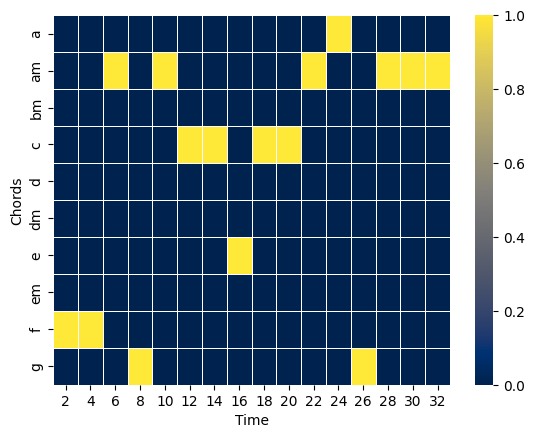

In [264]:

hm = sns.heatmap(heatData, cmap="cividis", yticklabels=CLASSES, xticklabels= keys, linewidths=0.5, linecolor='white') 


plt.xlabel("Time")
plt.ylabel("Chords")

ValueError: x and y must have same first dimension, but have shapes (1,) and (10,)

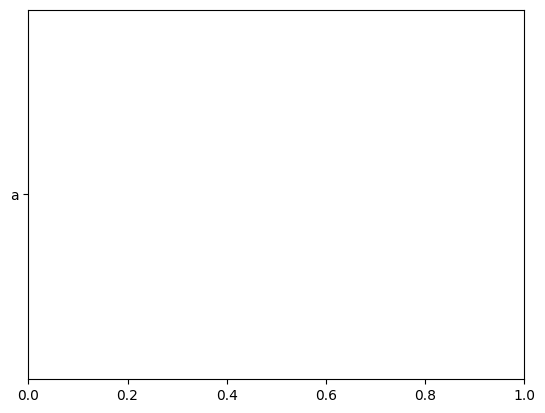

In [227]:
# Create a scatter plot
# plt.scatter(keys, CLASSES, marker='o', color='blue')
plt.plot(keys, CLASSES, marker="s", color='b')

# Add labels and a title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot')

# Show the plot
plt.show()